In [4]:
!pip install requests==2.31.0

###DATA RECOVER

In [4]:
import requests
import json
import pandas as pd

url = "https://donationsexperiment-default-rtdb.europe-west1.firebasedatabase.app/.json"
response = requests.get(url)
data = list(response.json().values())[:-2]
data = list(filter(lambda x: 'post' in x and not 'invalid' in x['pre'], data))
print('Total observations:', len(data))

Total observations: 250


###Groups

In [6]:
lenAnon = len(list(filter(lambda x: x['pre']['experiment_group'] == 'anonimo', data)))
lenNonAnon = len(data) - lenAnon
print('Anonymous:',lenAnon)
print('Non anonymous:', lenNonAnon)

Anonymous: 124
Non anonymous: 126



# JSON to CSV
The file can be found by clicking on the directory icon on the left: output.csv

In [5]:
import requests
import json
import pandas as pd

def flatten_dict(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        elif isinstance(v, list):
            for i, item in enumerate(v):
                if isinstance(item, dict):
                    items.extend(flatten_dict(item, new_key + sep + str(i), sep=sep).items())
                else:
                    items.append((new_key + sep + str(i), item))
        else:
            items.append((new_key, v))
    return dict(items)

flattened_data = []
for item in data:
    flattened_item = flatten_dict(item)
    flattened_data.append(flattened_item)

df = pd.DataFrame(flattened_data)
df.to_csv('output.csv', index=False)

### Participants data extraction
Average and median donation amounts for both groups + variance.

In [6]:
import pandas as pd
import numpy as np

all_data = []

for participant_data in data:
    experiment_group = participant_data['pre']['experiment_group']
    donation1_amount = participant_data['donation1']['amount']
    donation1_lives = participant_data['donation1']['lives']

    if donation1_lives != 0:
        donation_per_life = donation1_amount / donation1_lives
    else:
        donation_per_life = np.nan

    all_data.append([experiment_group, donation_per_life])

df = pd.DataFrame(all_data, columns=['experiment_group', 'donation_per_life'])

result = df.groupby('experiment_group')['donation_per_life'].agg(['mean',  'median', 'std', 'var'])


print('Relative donation amount (donation amount/available lives)')
print(result)

Relative donation amount (donation amount/available lives)
                      mean    median       std       var
experiment_group                                        
anonimo           0.451217  0.454545  0.292689  0.085667
non_anonimo       0.596734  0.555556  0.263495  0.069430


### Bar chart showing donation amounts across groups





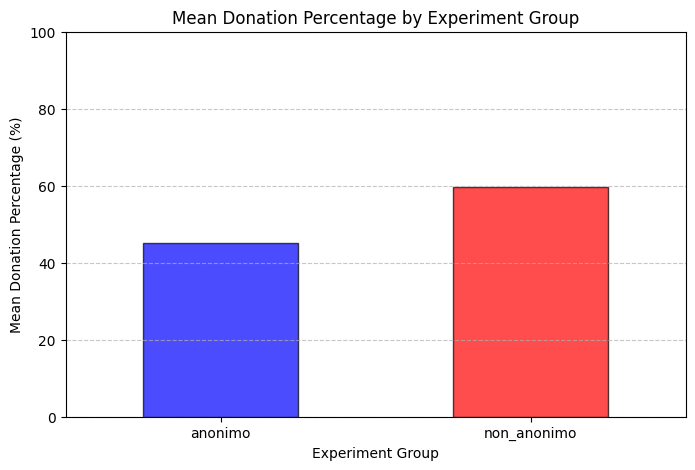

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

all_data = []
for participant_data in data:
    experiment_group = participant_data['pre']['experiment_group']
    donation1_amount = participant_data['donation1']['amount']
    donation1_lives = participant_data['donation1']['lives']


    donation_percentage = (donation1_amount / donation1_lives) * 100
    all_data.append([experiment_group, donation_percentage])

df = pd.DataFrame(all_data, columns=['experiment_group', 'donation_percentage'])

group_means = df.groupby('experiment_group')['donation_percentage'].mean()


plt.figure(figsize=(8, 5))
group_means.plot(kind='bar', color=['blue', 'red'], alpha=0.7, edgecolor='black')


plt.xlabel('Experiment Group')
plt.ylabel('Mean Donation Percentage (%)')
plt.title('Mean Donation Percentage by Experiment Group')
plt.xticks(rotation=0)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.show()



###Fraction of participants who donated in each group (%).
###Fraction of participants who donate all the lives (except 1 of course) in each group.

In [9]:
import pandas as pd

all_data = []
for participant_data in data:
    experiment_group = participant_data['pre']['experiment_group']
    donation1_amount = participant_data['donation1']['amount']
    donation1_lives = participant_data['donation1']['lives']

    if donation1_amount == 0:
        donor = 'No Donation'
    elif donation1_amount == donation1_lives - 1:
        donor = 'Max Donation'
    else:
        donor = 'Other'

    all_data.append([experiment_group, donor])


df = pd.DataFrame(all_data, columns=['experiment_group', 'donor'])

result1 = df.groupby(['experiment_group', 'donor']).size().unstack(fill_value=0)


result1['Total'] = result1.sum(axis=1)

percentages = result1.div(result1['Total'], axis=0) * 100

percentages = percentages.round(2)

combined_result = result1.astype(str) + "(" + percentages.astype(str) + "%)"

combined_result = combined_result[['Total'] + [col for col in combined_result.columns if col != 'Total']]

print(combined_result)


donor                   Total Max Donation No Donation       Other
experiment_group                                                  
anonimo           124(100.0%)   23(18.55%)  22(17.74%)  79(63.71%)
non_anonimo       126(100.0%)    47(37.3%)    4(3.17%)  75(59.52%)


In [10]:
delta = result.iloc[1]['mean'] - result.iloc[0]['mean']
print('Difference in relative donation amount between groups:' , (delta * 100), '%')

Difference in relative donation amount between groups: 14.551753645455644 %


In [17]:
df = pd.DataFrame(flattened_data).sort_values(by=['pre_experiment_group', 'pre_start_time'])
df['lives_received'] = df['donation1_amount'].shift(1)
df['2nd_lives'] = df['donation2_amount'].shift(1)

df = df.reset_index()

rows = df.iterrows()
for index, row in rows:
    if (row['lives_received'] <= 0):
      for i in range(index, 0, -1):
        if (df.at[i, 'lives_received'] != 0):
          df.at[index, 'lives_received'] = df.at[i, 'lives_received']
          break

    df.at[index, '2nd_lives'] = row['lives_received'] + (row['donation1_lives'] - row['donation1_amount'])

# questo calcolo da come corretto il numero di vite della partita 1 (anche se 500 * lives1 non è il dato preciso essendoci ceil)
df['scoreAt1'] = 500 * df['donation1_lives']
df['scoreAt2'] = df['totalScore'] - df['scoreAt1']
df['scoreAt1_adj'] = df['scoreAt1'] / 5
df['scoreAt2_adj'] = df['scoreAt2'] / (df['2nd_lives'])
# questo calcolo da come corretto il numero di vite della partita 2 (anche se 500 * lives2 non è il dato preciso essendoci ceil)
df['scoreAt2FromLives'] = df['donation2_lives'] * 500
df['scoreAt2FromLives_adj'] = df['scoreAt2FromLives'] / (df['2nd_lives'])
df['scoreAt1'] = df['totalScore'] - df['scoreAt2FromLives']
df['scoreAt1_adj'] = df['scoreAt1'] / 5
# questo calcolo fa la media usando 250 (per via del ceil)
df['scoreAt1'] = 250 * df['donation1_lives']
df['scoreAt2'] = df['totalScore'] - df['scoreAt1']
df['scoreAt1_adj'] = df['scoreAt1'] / 5
df['scoreAt2_adj'] = df['scoreAt2'] / (df['2nd_lives'])

df['score_diff'] = df['scoreAt2FromLives'] - df['scoreAt1']


df

,index,donation1_amount,donation1_lives,donation1_message,donation1_name,donation2_amount,donation2_lives,donation2_message,donation2_name,post_overall_evaluation,...,pre_personal_info_taking_experiments,lives_received,2nd_lives,scoreAt1,scoreAt2,scoreAt1_adj,scoreAt2_adj,scoreAt2FromLives,scoreAt2FromLives_adj,score_diff
0,96,0,2,,,0.0,3.0,,,4.0,...,2.0,NaN,NaN,500,710,100.0,NaN,1500.0,NaN,1000.0
1,12,2,3,,,2.0,3.0,,,NaN,...,1.0,0.0,1.0,750,1940,150.0,1940.000000,1500.0,1500.000000,750.0
2,43,0,2,,,0.0,3.0,,,1.0,...,4.0,2.0,4.0,500,1710,100.0,427.500000,1500.0,375.000000,1000.0
3,48,0,10,,,0.0,13.0,,,5.0,...,4.0,2.0,10.0,2500,8250,500.0,825.000000,6500.0,650.000000,4000.0
4,85,1,3,,,1.0,5.0,,,5.0,...,2.0,2.0,2.0,750,2720,150.0,1360.000000,2500.0,1250.000000,1750.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,231,7,8,Have fun!,Emi,7.0,7.0,Have fun!,Emi,4.0,...,NaN,1.0,2.0,2000,4921,400.0,2460.500000,3500.0,1750.000000,1500.0
246,125,5,9,Donnation \n,Petroo,5.0,10.0,Donnation \n,Petroo,5.0,...,NaN,7.0,11.0,2250,6694,450.0,608.545455,5000.0,454.545455,2750.0
247,173,4,7,❤️,J,4.0,9.0,❤️,J,5.0,...,NaN,5.0,8.0,1750,6070,350.0,758.750000,4500.0,562.500000,2750.0
248,247,10,11,Here you go,JA,10.0,11.0,Here you go,JA,5.0,...,NaN,4.0,5.0,2750,7910,550.0,1582.000000,5500.0,1100.000000,2750.0


###Scatterplot for lives received and second-round performance

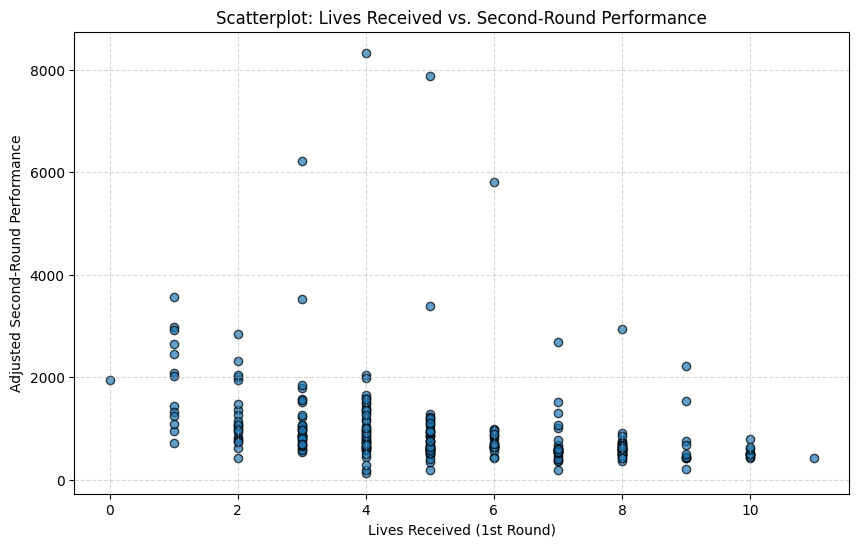

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.scatter(df['lives_received'], df['scoreAt2_adj'], alpha=0.7, edgecolors='k')

plt.xlabel('Lives Received (1st Round)')
plt.ylabel('Adjusted Second-Round Performance')
plt.title('Scatterplot: Lives Received vs. Second-Round Performance')
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()


### Scatterplot for first round performance and lives donated

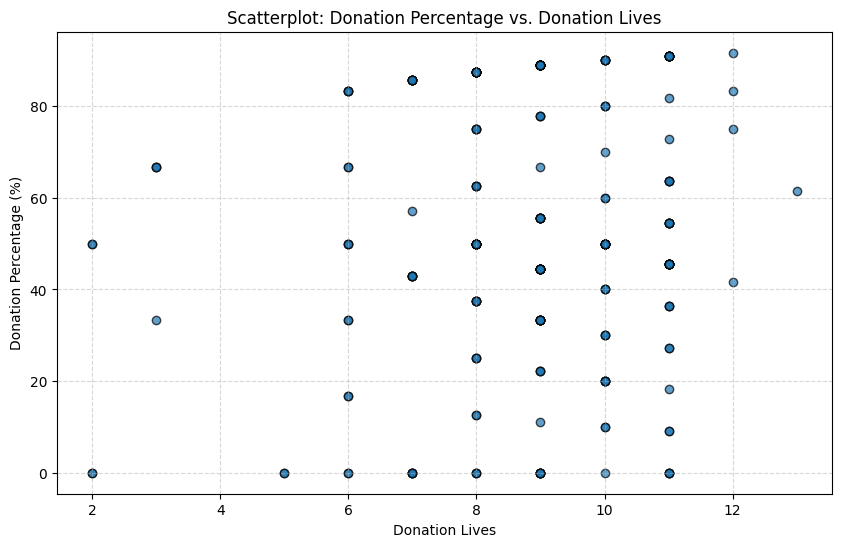

In [21]:
import matplotlib.pyplot as plt

df['donation_percentage'] = (df['donation1_amount'] / df['donation1_lives']) * 100

plt.figure(figsize=(10, 6))

plt.scatter(df['donation1_lives'], df['donation_percentage'], alpha=0.7, edgecolors='k')

plt.xlabel('Donation Lives')
plt.ylabel('Donation Percentage (%)')
plt.title('Scatterplot: Donation Percentage vs. Donation Lives')
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()



###Second-round performance comparison between groups.

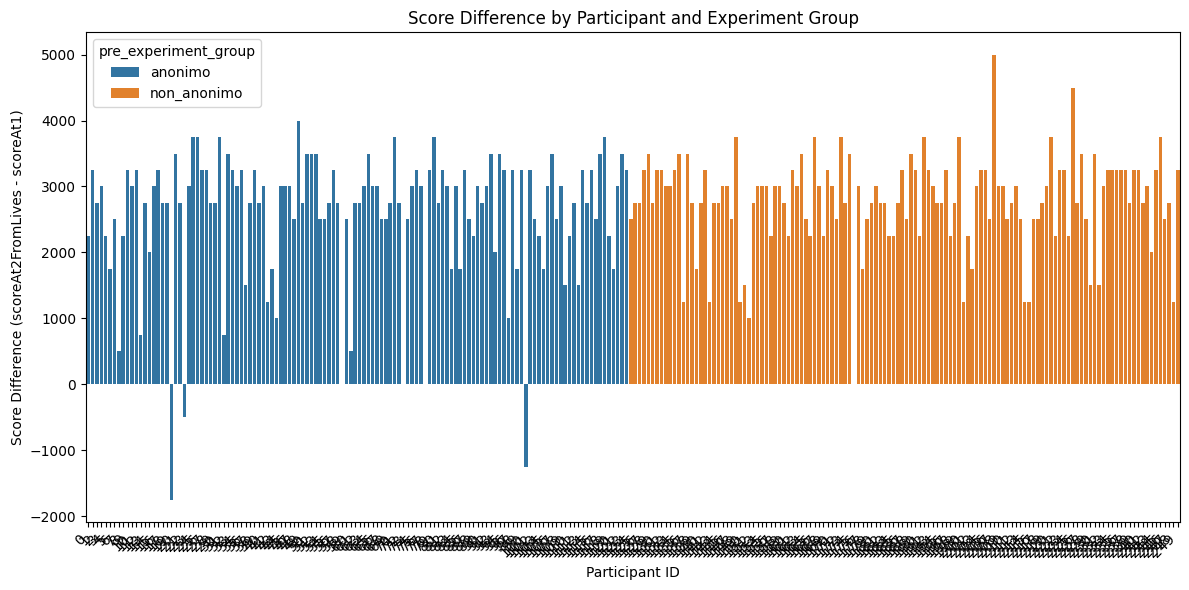

In [12]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x='index', y='score_diff', hue='pre_experiment_group', data=df)
plt.xlabel('Participant ID')
plt.ylabel('Score Difference (scoreAt2FromLives - scoreAt1)')
plt.title('Score Difference by Participant and Experiment Group')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


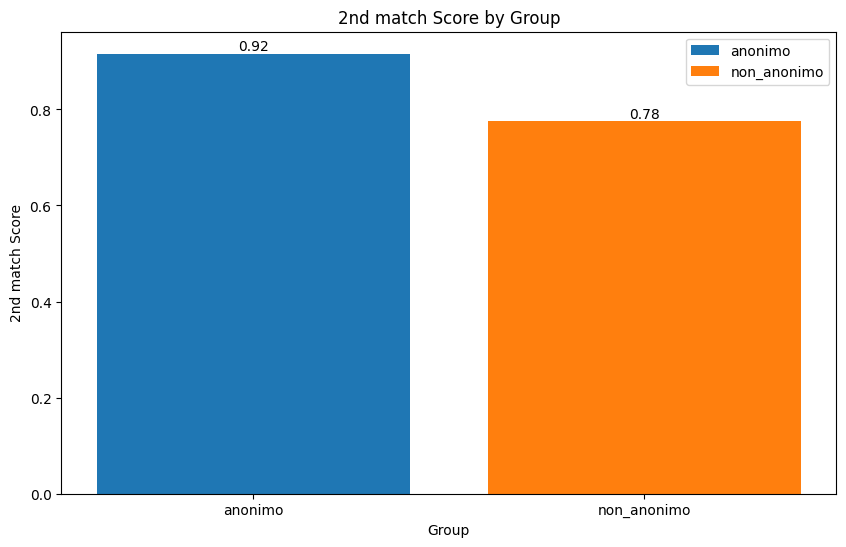

In [13]:

import matplotlib.pyplot as plt


donation_amounts = []
devices = []

for i, participant_data in df.iterrows():
    donation_amounts.append((participant_data['scoreAt2FromLives_adj'] - participant_data['scoreAt1_adj']) / participant_data['scoreAt1_adj'])
    devices.append(participant_data['pre_experiment_group'])

import pandas as pd
df_plot = pd.DataFrame({                      'donation_amount': donation_amounts,
                       'device': devices})

grouped_data = df_plot.groupby(['device'])['donation_amount'].mean().reset_index()

plt.figure(figsize=(10, 6))

for device in grouped_data['device'].unique():
    device_data = grouped_data[grouped_data['device'] == device]
    plt.bar(device_data['device'], device_data['donation_amount'], label=device)

plt.xlabel('Group')
plt.ylabel('2nd match Score')
plt.title('2nd match Score by Group')
for i, v in enumerate(grouped_data['donation_amount']):
    plt.text(i, v, str(round(v, 2)), ha='center', va='bottom')
plt.legend()
plt.show()

In [14]:
df['lives1_adj'] = df['donation1_lives'] / 5
df['lives2_adj'] = df['donation2_lives'] / df['2nd_lives']
df['lives_diff'] = df['lives2_adj'] - df['lives1_adj']
df['lives_diff_abs'] = df['donation2_lives'] - df['donation1_lives']

### NO Lives Difference by Participant and Experiment Group

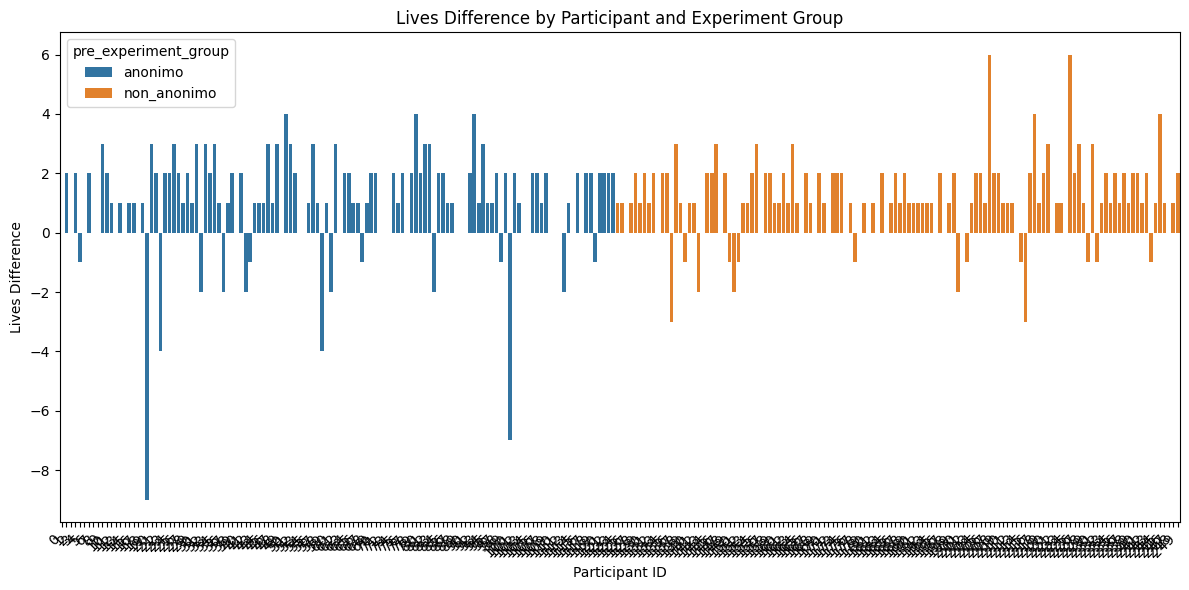

In [15]:


import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(12, 6))
sns.barplot(x='index', y='lives_diff_abs', hue='pre_experiment_group', data=df)
plt.xlabel('Participant ID')
plt.ylabel('Lives Difference')
plt.title('Lives Difference by Participant and Experiment Group')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


### NO 2nd match Lives % on Lives 1 by Group

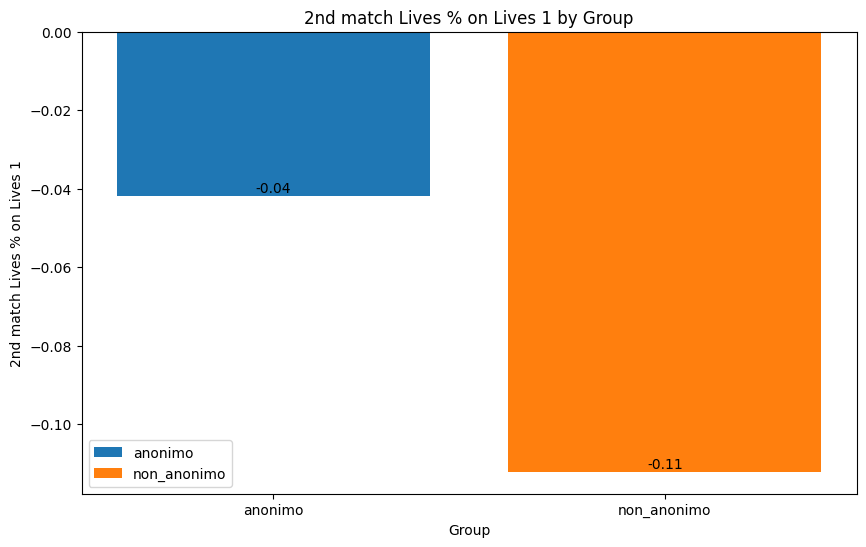

In [16]:

import matplotlib.pyplot as plt


donation_amounts = []
devices = []

for i, participant_data in df.iterrows():
    donation_amounts.append((participant_data['lives_diff']) / participant_data['lives1_adj'])
    devices.append(participant_data['pre_experiment_group'])

import pandas as pd
df_plot = pd.DataFrame({                      'donation_amount': donation_amounts,
                       'device': devices})

grouped_data = df_plot.groupby(['device'])['donation_amount'].mean().reset_index()

plt.figure(figsize=(10, 6))

for device in grouped_data['device'].unique():
    device_data = grouped_data[grouped_data['device'] == device]
    plt.bar(device_data['device'], device_data['donation_amount'], label=device)

plt.xlabel('Group')
plt.ylabel('2nd match Lives % on Lives 1')
plt.title('2nd match Lives % on Lives 1 by Group')

for i, v in enumerate(grouped_data['donation_amount']):
    plt.text(i, v, str(round(v, 2)), ha='center', va='bottom')
plt.legend()
plt.show()

### Histogram of Donation per life by Experiment Group

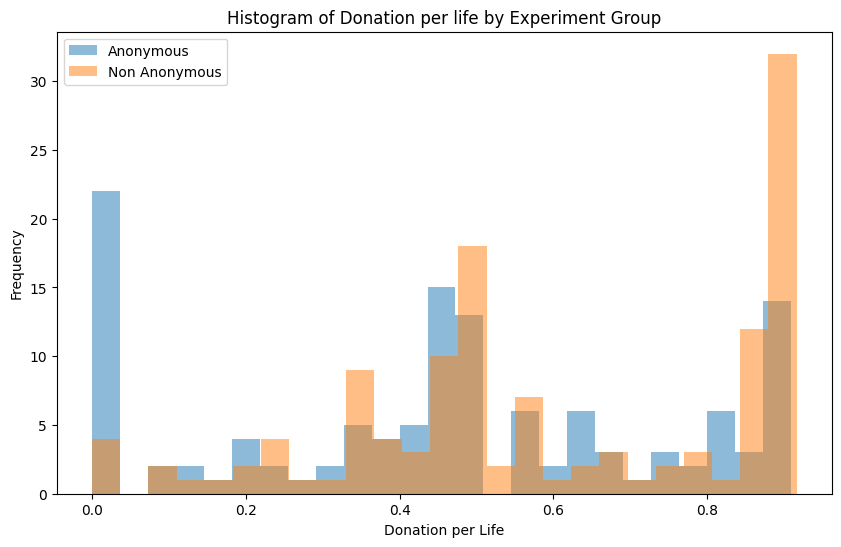

In [17]:
import matplotlib.pyplot as plt

all_data = []
for participant_data in data:
    experiment_group = participant_data['pre']['experiment_group']
    donation1_amount = participant_data['donation1']['amount']
    donation1_lives = participant_data['donation1']['lives']

    if donation1_lives != 0:
        donation_per_life = donation1_amount / donation1_lives
    else:
        donation_per_life = np.nan

    all_data.append([experiment_group, donation_per_life])

df = pd.DataFrame(all_data, columns=['experiment_group', 'donation_per_life'])


plt.figure(figsize=(10, 6))
plt.hist(df[df['experiment_group'] == 'anonimo']['donation_per_life'], alpha=0.5, label='Anonymous', bins=25)
plt.hist(df[df['experiment_group'] == 'non_anonimo']['donation_per_life'], alpha=0.5, label='Non Anonymous', bins=25)
plt.xlabel('Donation per Life')
plt.ylabel('Frequency')
plt.title('Histogram of Donation per life by Experiment Group')
plt.legend()
plt.show()

###T-TEST (Donation per Life)

In [18]:
from scipy.stats import ttest_ind

group_anonimo = df[df['experiment_group'] == 'anonimo']['donation_per_life'].dropna()
group_non_anonimo = df[df['experiment_group'] == 'non_anonimo']['donation_per_life'].dropna()


t_statistic, p_value = ttest_ind(group_anonimo, group_non_anonimo)


In [19]:

t_statistic, p_value = ttest_ind(group_anonimo, group_non_anonimo)

alpha = 0.05  # Significance level

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("The difference between the groups is statistically significant.")
else:
    print("The difference between the groups is not statistically significant.")

T-statistic: -4.1327480714468985
P-value: 4.9060445787739054e-05
The difference between the groups is statistically significant.


###Mann-Whitney U statistic

In [20]:
from scipy.stats import mannwhitneyu

group_anonimo = df[df['experiment_group'] == 'anonimo']['donation_per_life'].dropna()
group_non_anonimo = df[df['experiment_group'] == 'non_anonimo']['donation_per_life'].dropna()


stat, p_value = mannwhitneyu(group_anonimo, group_non_anonimo, alternative='less')

print("Mann-Whitney U statistic:", stat)
print("p-value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Group Anonymous is stochastically less than Group Non Anonymous.")
else:
    print("Fail to reject the null hypothesis: No evidence that Group Anonymous is stochastically less than Group Non anonymous.")


Mann-Whitney U statistic: 5526.5
p-value: 3.083071370740708e-05
Reject the null hypothesis: Group Anonymous is stochastically less than Group Non Anonymous.


### TotalScore scatterplot

<ipython-input-24-1e3d7e364bb9>:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(donation_lives, donation_amounts, c=['red' if group == 'non_anonimo' else 'blue' for group in experiment_groups], cmap='viridis')


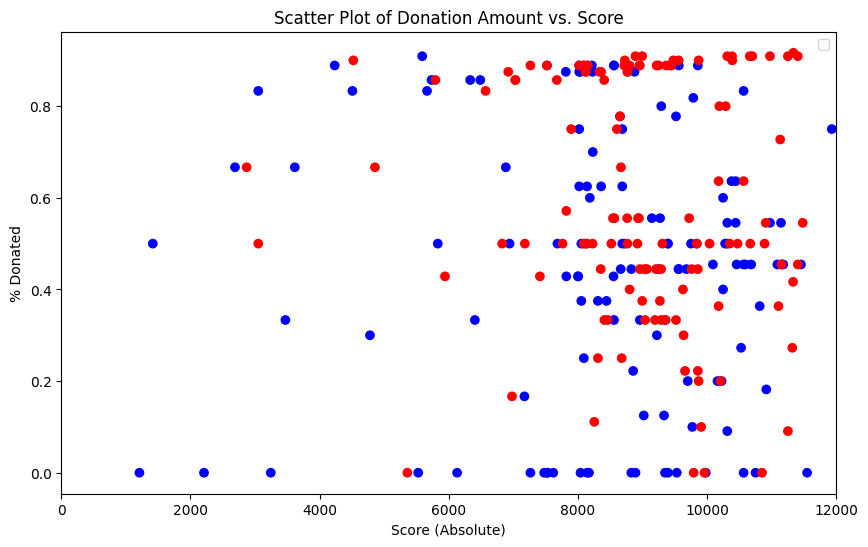

In [24]:
import matplotlib.pyplot as plt

donation_amounts = []
donation_lives = []
experiment_groups = []

for participant_data in data:
    experiment_groups.append(participant_data['pre']['experiment_group'])
    donation_amounts.append(participant_data['donation1']['amount'] / participant_data['donation1']['lives'])
    donation_lives.append(participant_data['totalScore'] if 'totalScore' in participant_data else 0)

plt.figure(figsize=(10, 6))
plt.scatter(donation_lives, donation_amounts, c=['red' if group == 'non_anonimo' else 'blue' for group in experiment_groups], cmap='viridis')
plt.xlabel('Score (Absolute)')
plt.xlim(0, 12000)
plt.ylabel('% Donated')
plt.title('Scatter Plot of Donation Amount vs. Score')
plt.legend()
plt.show()

 ### NO

<ipython-input-25-d7626f9adafc>:38: UserWarning: linewidths is ignored by contourf
  plt.contourf(xx, yy, Z, alpha=0.3, levels=[0, 0.5, 1], linewidths=0.8, cmap=cmap_background)


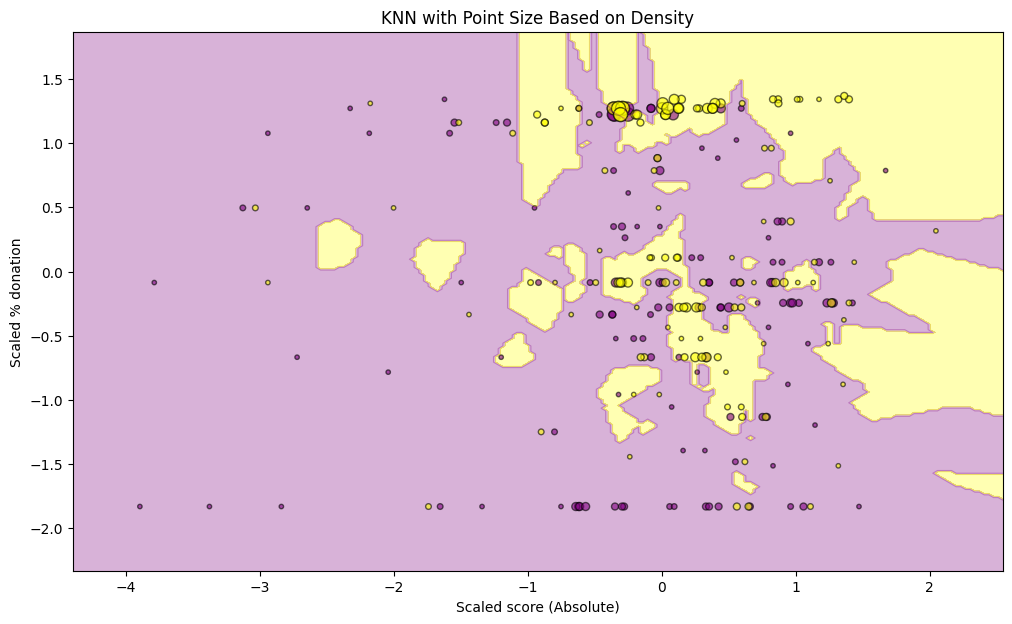

In [25]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap
from scipy.spatial import cKDTree

X = np.column_stack((donation_lives, donation_amounts))
y = np.array(experiment_groups)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

knn = KNeighborsClassifier(n_neighbors=4, weights='uniform', p=2)
knn.fit(X_scaled, y_encoded)

x_min, x_max = X_scaled[:, 0].min() - 0.5, X_scaled[:, 0].max() + 0.5
y_min, y_max = X_scaled[:, 1].min() - 0.5, X_scaled[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(12, 7))
cmap_background = ListedColormap(['purple', 'yellow'])
cmap_points = ListedColormap(['purple', 'yellow'])

plt.contourf(xx, yy, Z, alpha=0.3, levels=[0, 0.5, 1], linewidths=0.8, cmap=cmap_background)
plt.contour(xx, yy, Z, alpha=0.3, levels=[0, 0.5, 1], linewidths=0.8, cmap=cmap_background)

tree = cKDTree(X_scaled)

radius = 0.1  # You can adjust this value based on your data

density = np.array([len(tree.query_ball_point(point, radius)) for point in X_scaled])

sizes = np.clip(density / density.max() * 100, 10, 100)

plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_encoded, cmap=cmap_points, edgecolor='k', s=sizes, alpha=0.6)


plt.xlabel('Scaled score (Absolute)')
plt.ylabel('Scaled % donation')
plt.title('KNN with Point Size Based on Density')

plt.show()


### NO Lives scatterplot

<ipython-input-23-8965440cb1c3>:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(donation_lives, donation_amounts, c=['red' if group == 'non_anonimo' else 'blue' for group in experiment_groups], cmap='brg')


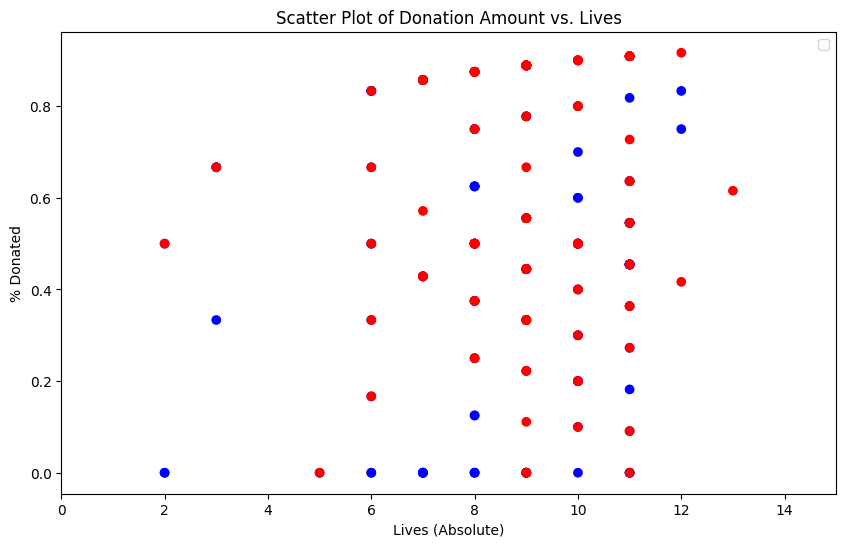

In [23]:
import matplotlib.pyplot as plt

donation_amounts = []
donation_lives = []
experiment_groups = []

for participant_data in data:
    experiment_groups.append(participant_data['pre']['experiment_group'])
    donation_amounts.append(participant_data['donation1']['amount'] / participant_data['donation1']['lives'])
    donation_lives.append(participant_data['donation1']['lives'])


plt.figure(figsize=(10, 6))
plt.scatter(donation_lives, donation_amounts, c=['red' if group == 'non_anonimo' else 'blue' for group in experiment_groups], cmap='brg')
plt.xlabel('Lives (Absolute)')
plt.xlim(0, 15)
plt.ylabel('% Donated')
plt.title('Scatter Plot of Donation Amount vs. Lives')
plt.legend()
plt.show()

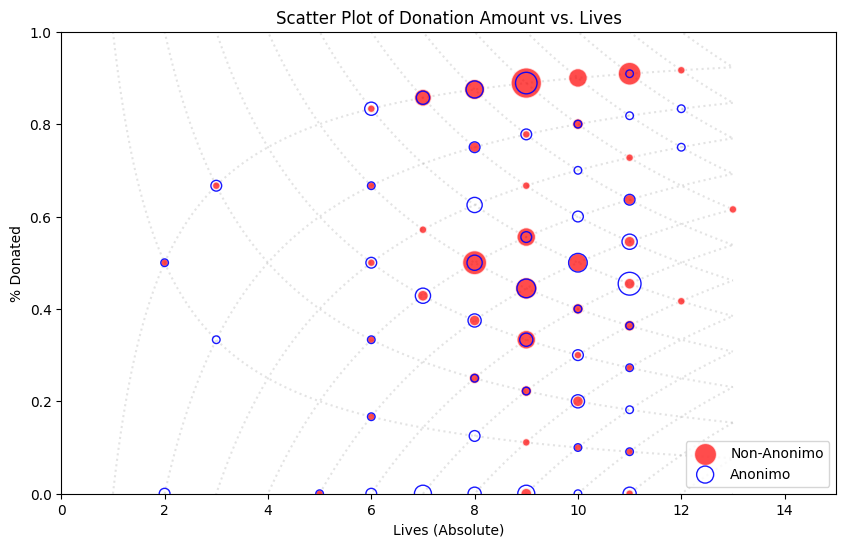

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

donation_amounts = []
donation_lives = []
experiment_groups = []

for participant_data in data:
    experiment_groups.append(participant_data['pre']['experiment_group'])
    donation_amounts.append(participant_data['donation1']['amount'] / participant_data['donation1']['lives'])
    donation_lives.append(participant_data['donation1']['lives'])

points = list(zip(donation_lives, donation_amounts, experiment_groups))

grouped_counts = {'non_anonimo': Counter(), 'anonimo': Counter()}

for life, amount, group in points:
    grouped_counts[group][(life, amount)] += 1

plot_data = {}
for group, counter in grouped_counts.items():
    unique_points = np.array(list(counter.keys()))
    sizes = np.array(list(counter.values())) * 30
    plot_data[group] = (unique_points[:, 0], unique_points[:, 1], sizes)

plt.figure(figsize=(10, 6))

max_lives = max(donation_lives)
x_values = np.linspace(1, max_lives, 1000)
for n in range(1, max_lives + 1):
    y_values = (x_values - n) / x_values
    plt.plot(x_values, y_values, linestyle=':', alpha=0.2, color='#777', zorder=1)

for n in range(1, max_lives + 1):
    z_values = n / x_values
    plt.plot(x_values, z_values, linestyle=':', alpha=0.2, color='#777', zorder=2 )

for group, (lives, amounts, sizes) in plot_data.items():
    color = 'red' if group == 'non_anonimo' else 'none'
    edgecolor = 'white' if group == 'non_anonimo' else 'blue'
    alpha = 0.7 if group == 'non_anonimo' else 0.9
    marker = 'o' if group == 'non_anonimo' else 'o'
    label = 'Non-Anonimo' if group == 'non_anonimo' else 'Anonimo'
    plt.scatter(lives, amounts, s=sizes, c=color, marker=marker, alpha=alpha, label=label, edgecolors=edgecolor, zorder=7)

plt.xlabel('Lives (Absolute)')
plt.xlim(0, 15)
plt.ylabel('% Donated')
plt.ylim(0, 1)
plt.title('Scatter Plot of Donation Amount vs. Lives')
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))
plt.grid(False)
plt.show()



### Graph on self assessed generosity and lives donated

<ipython-input-25-7da02c9b438b>:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(donation_gen, donation_amounts, c=['red' if group == 'non_anonimo' else 'blue' for group in experiment_groups], cmap='viridis')


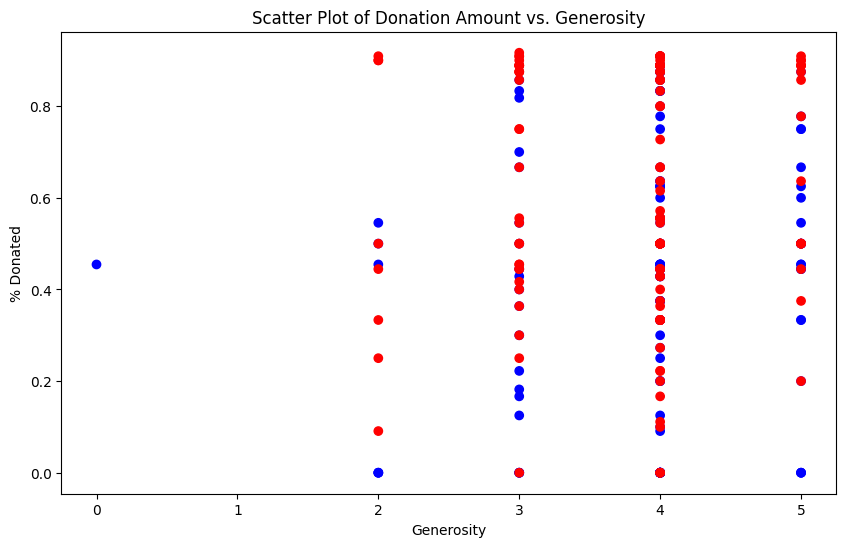

In [25]:

donation_amounts = []
donation_gen = []
experiment_groups = []

for participant_data in data:
    experiment_groups.append(participant_data['pre']['experiment_group'])
    donation_amounts.append(participant_data['donation1']['amount'] / participant_data['donation1']['lives'])
    donation_gen.append(participant_data['pre']['personal_info']['generous'] if 'personal_info' in participant_data['pre'] else 0)

plt.figure(figsize=(10, 6))
plt.scatter(donation_gen, donation_amounts, c=['red' if group == 'non_anonimo' else 'blue' for group in experiment_groups], cmap='viridis')
plt.scatter([], [], c='red', label='Non anonym')
plt.scatter([], [], c='blue', label='Anonym')
plt.xlabel('Generosity')
plt.ylabel('% Donated')
plt.title('Scatter Plot of Donation Amount vs. Generosity')
plt.show()

### Competitiveness scatter plot

<ipython-input-26-127731ce795f>:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(donation_comp, donation_amounts, c=['red' if group == 'non_anonimo' else 'blue' for group in experiment_groups], cmap='viridis')


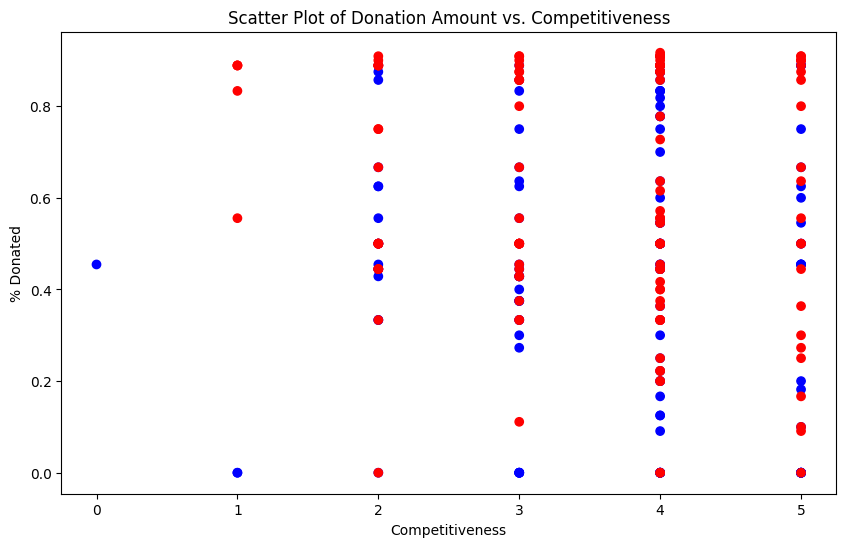

In [26]:
donation_amounts = []
donation_comp = []
experiment_groups = []

for participant_data in data:
    experiment_groups.append(participant_data['pre']['experiment_group'])
    donation_amounts.append(participant_data['donation1']['amount'] / participant_data['donation1']['lives'])
    donation_comp.append(participant_data['pre']['personal_info']['competitive'] if 'personal_info' in participant_data['pre'] else 0)

plt.figure(figsize=(10, 6))
plt.scatter(donation_comp, donation_amounts, c=['red' if group == 'non_anonimo' else 'blue' for group in experiment_groups], cmap='viridis')
plt.scatter([], [], c='red', label='Non anonym')
plt.scatter([], [], c='blue', label='Anonym')
plt.xlabel('Competitiveness')
plt.ylabel('% Donated')
plt.title('Scatter Plot of Donation Amount vs. Competitiveness')
plt.show()

### Donation Amount vs. Donation impact understanding

<ipython-input-27-6f33b602a656>:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(donation_gen, donation_amounts, c=['red' if group == 'non_anonimo' else 'blue' for group in experiment_groups], cmap='viridis')


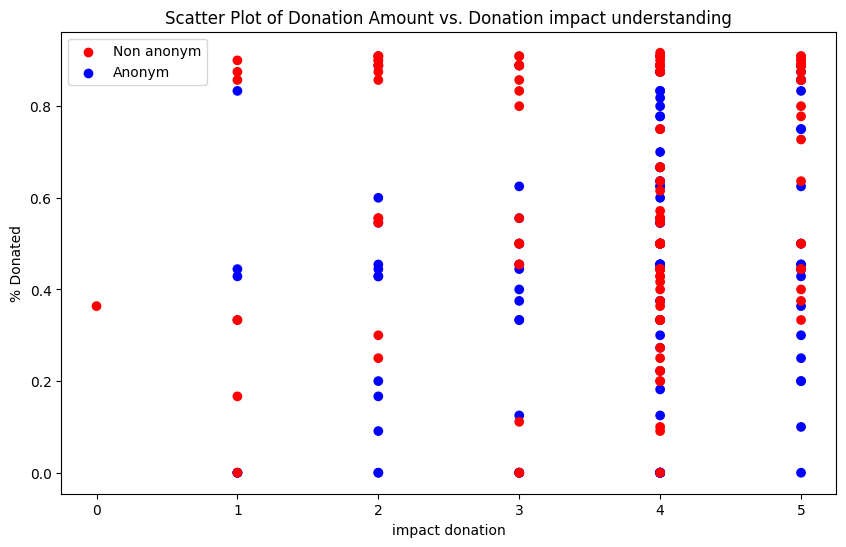

In [27]:
donation_amounts = []
donation_gen = []
experiment_groups = []

for participant_data in data:
    experiment_groups.append(participant_data['pre']['experiment_group'])
    donation_amounts.append(participant_data['donation1']['amount'] / participant_data['donation1']['lives'])
    donation_gen.append(((participant_data['post']['post_survey']['understood_donation_impact']if 'understood_donation_impact' in participant_data['post']['post_survey'] else 0)))

plt.figure(figsize=(10, 6))
plt.scatter(donation_gen, donation_amounts, c=['red' if group == 'non_anonimo' else 'blue' for group in experiment_groups], cmap='viridis')
plt.scatter([], [], c='red', label='Non anonym')
plt.scatter([], [], c='blue', label='Anonym')
plt.xlabel('impact donation')
plt.ylabel('% Donated')
plt.title('Scatter Plot of Donation Amount vs. Donation impact understanding')
plt.legend()
plt.show()

### Donation and bad feeling of losing lives

<ipython-input-28-1cd1f6d47251>:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(donation_gen, donation_amounts, c=['red' if group == 'non_anonimo' else 'blue' for group in experiment_groups], cmap='viridis')


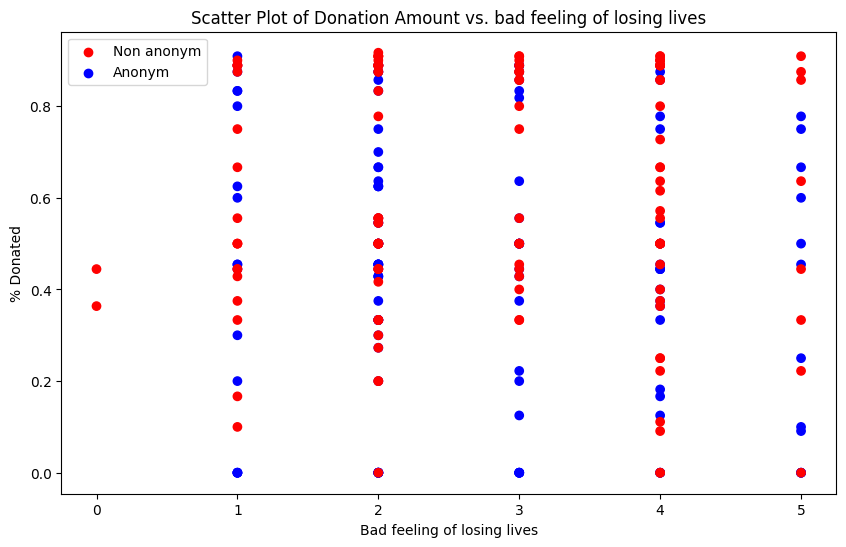

In [28]:
donation_amounts = []
donation_gen = []
experiment_groups = []

for participant_data in data:
    experiment_groups.append(participant_data['pre']['experiment_group'])
    donation_amounts.append(participant_data['donation1']['amount'] / participant_data['donation1']['lives'])
    donation_gen.append(((participant_data['post']['post_survey']['bad_losing_lives']if 'bad_losing_lives' in participant_data['post']['post_survey'] else 0)))

plt.figure(figsize=(10, 6))
plt.scatter(donation_gen, donation_amounts, c=['red' if group == 'non_anonimo' else 'blue' for group in experiment_groups], cmap='viridis')
plt.scatter([], [], c='red', label='Non anonym')
plt.scatter([], [], c='blue', label='Anonym')
plt.xlabel('Bad feeling of losing lives')
plt.ylabel('% Donated')
plt.title('Scatter Plot of Donation Amount vs. bad feeling of losing lives')
plt.legend()
plt.show()

### Graph on perceived effort to gain lives and donations

<ipython-input-29-d029ab340528>:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(donation_gen, donation_amounts, c=['red' if group == 'non_anonimo' else 'blue' for group in experiment_groups], cmap='viridis')


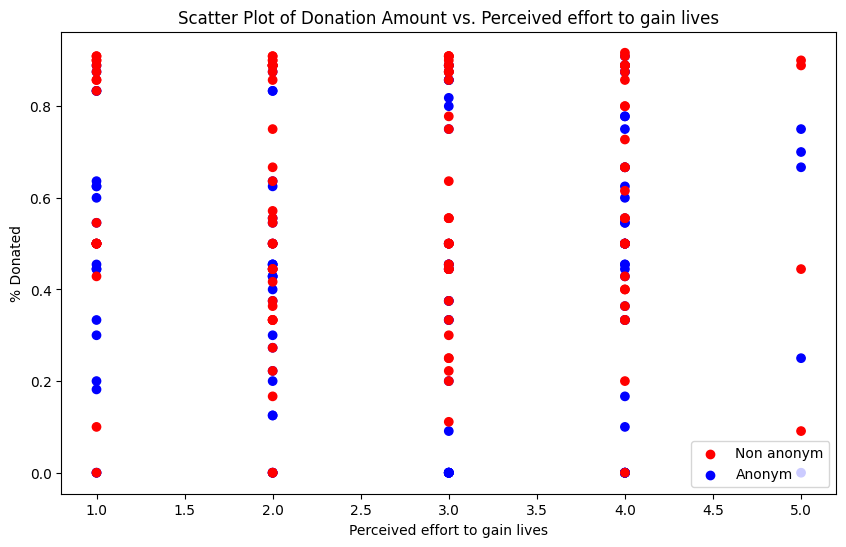

In [29]:
donation_amounts = []
donation_gen = []
experiment_groups = []

for participant_data in data:
    experiment_groups.append(participant_data['pre']['experiment_group'])
    donation_amounts.append(participant_data['donation1']['amount'] / participant_data['donation1']['lives'])
    donation_gen.append(((participant_data['post']['post_survey']['effort_lives']if 'effort_lives' in participant_data['post']['post_survey'] else 0)))

plt.figure(figsize=(10, 6))
plt.scatter(donation_gen, donation_amounts, c=['red' if group == 'non_anonimo' else 'blue' for group in experiment_groups], cmap='viridis')
plt.scatter([], [], c='red', label='Non anonym')
plt.scatter([], [], c='blue', label='Anonym')
plt.xlabel('Perceived effort to gain lives')
plt.ylabel('% Donated')
plt.title('Scatter Plot of Donation Amount vs. Perceived effort to gain lives')
plt.legend()
plt.show()

### Graph on perceived pressure to donate and donations

<ipython-input-30-8dc4d69d464b>:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(donation_gen, donation_amounts, c=['red' if group == 'non_anonimo' else 'blue' for group in experiment_groups], cmap='viridis')


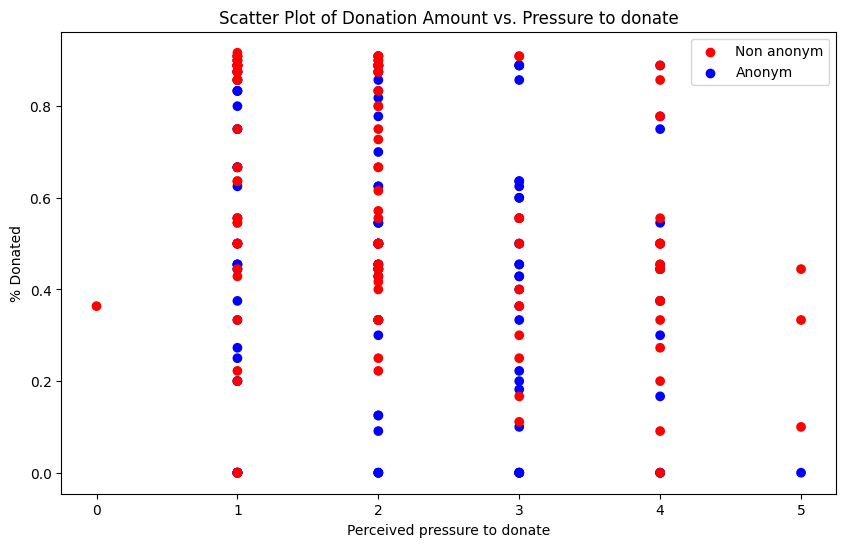

In [30]:
donation_amounts = []
donation_gen = []
experiment_groups = []

for participant_data in data:
    experiment_groups.append(participant_data['pre']['experiment_group'])
    donation_amounts.append(participant_data['donation1']['amount'] / participant_data['donation1']['lives'])
    donation_gen.append(((participant_data['post']['post_survey']['pressure_donate']if 'pressure_donate' in participant_data['post']['post_survey'] else 0)))

plt.figure(figsize=(10, 6))
plt.scatter(donation_gen, donation_amounts, c=['red' if group == 'non_anonimo' else 'blue' for group in experiment_groups], cmap='viridis')
plt.scatter([], [], c='red', label='Non anonym')
plt.scatter([], [], c='blue', label='Anonym')
plt.xlabel('Perceived pressure to donate')
plt.ylabel('% Donated')
plt.title('Scatter Plot of Donation Amount vs. Pressure to donate')
plt.legend()
plt.show()

### Graph on perception of Good playing and donations

<ipython-input-23-9800d4d02e9a>:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(donation_gen, donation_amounts, c=['red' if group == 'non_anonimo' else 'blue' for group in experiment_groups], cmap='viridis')


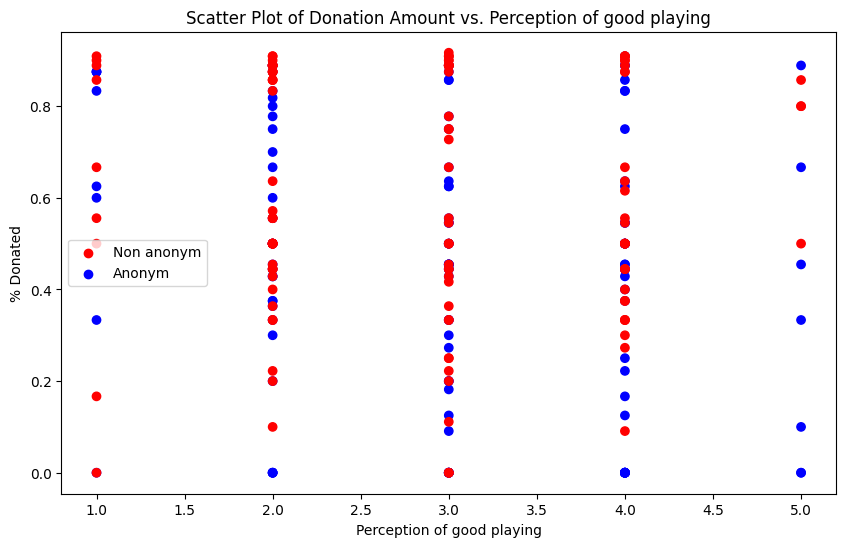

In [23]:
donation_amounts = []
donation_gen = []
experiment_groups = []

for participant_data in data:
    experiment_groups.append(participant_data['pre']['experiment_group'])
    donation_amounts.append(participant_data['donation1']['amount'] / participant_data['donation1']['lives'])
    donation_gen.append(((participant_data['post']['post_survey']['good_playing']if 'good_playing' in participant_data['post']['post_survey'] else 0)))

plt.figure(figsize=(10, 6))
plt.scatter(donation_gen, donation_amounts, c=['red' if group == 'non_anonimo' else 'blue' for group in experiment_groups], cmap='viridis')
plt.scatter([], [], c='red', label='Non anonym')
plt.scatter([], [], c='blue', label='Anonym')
plt.xlabel('Perception of good playing')
plt.ylabel('% Donated')
plt.title('Scatter Plot of Donation Amount vs. Perception of good playing')
plt.legend()
plt.show()

### Donations and overall evaluation

<ipython-input-31-7d94d156982e>:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(donation_gen, donation_amounts, c=['red' if group == 'non_anonimo' else 'blue' for group in experiment_groups], cmap='viridis')


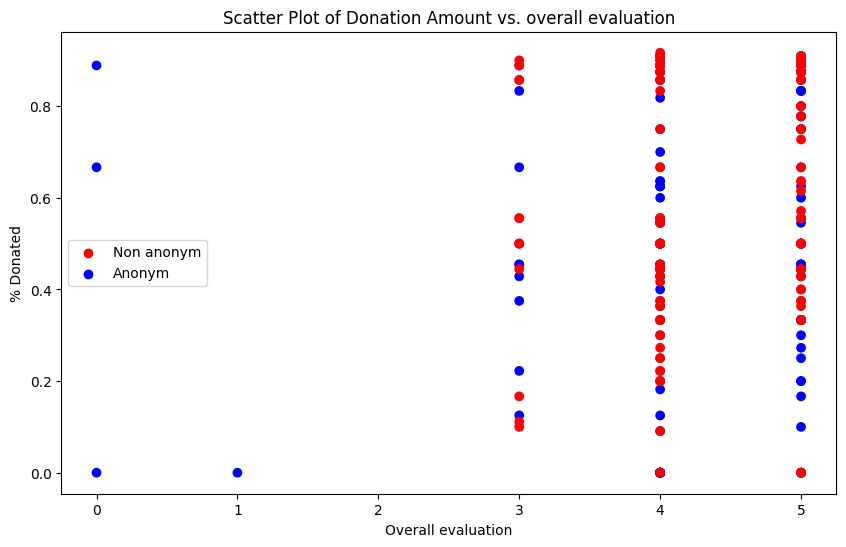

In [31]:
donation_amounts = []
donation_gen = []
experiment_groups = []

for participant_data in data:
    experiment_groups.append(participant_data['pre']['experiment_group'])
    donation_amounts.append(participant_data['donation1']['amount'] / participant_data['donation1']['lives'])
    donation_gen.append(((participant_data['post']['overall_evaluation']if 'overall_evaluation' in participant_data['post'] else 0)))

plt.figure(figsize=(10, 6))
plt.scatter(donation_gen, donation_amounts, c=['red' if group == 'non_anonimo' else 'blue' for group in experiment_groups], cmap='viridis')
plt.scatter([], [], c='red', label='Non anonym')
plt.scatter([], [], c='blue', label='Anonym')
plt.xlabel('Overall evaluation')
plt.ylabel('% Donated')
plt.title('Scatter Plot of Donation Amount vs. overall evaluation')
plt.legend()
plt.show()

### NO Browser Bar chart

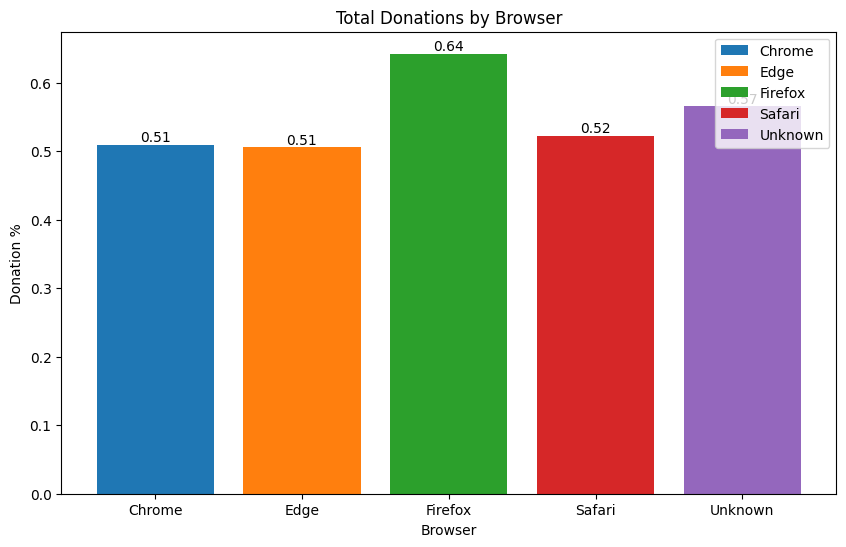

In [32]:

import matplotlib.pyplot as plt


donation_amounts = []
devices = []

for participant_data in data:
    donation_amounts.append(participant_data['donation1']['amount'] / participant_data['donation1']['lives'])
    devices.append(participant_data['pre']['browser'] if 'browser' in participant_data['pre'] else 'Unknown')

import pandas as pd
df_plot = pd.DataFrame({                      'donation_amount': donation_amounts,
                       'device': devices})

grouped_data = df_plot.groupby(['device'])['donation_amount'].mean().reset_index()

plt.figure(figsize=(10, 6))

for device in grouped_data['device'].unique():
    device_data = grouped_data[grouped_data['device'] == device]
    plt.bar(device_data['device'], device_data['donation_amount'], label=device)

for i, v in enumerate(grouped_data['donation_amount']):
    plt.text(i, v, str(round(v, 2)), ha='center', va='bottom')
plt.xlabel('Browser')
plt.ylabel('Donation %')
plt.title('Total Donations by Browser')
plt.legend()
plt.show()

### NO (Avg Lives per group barchart 1st match)

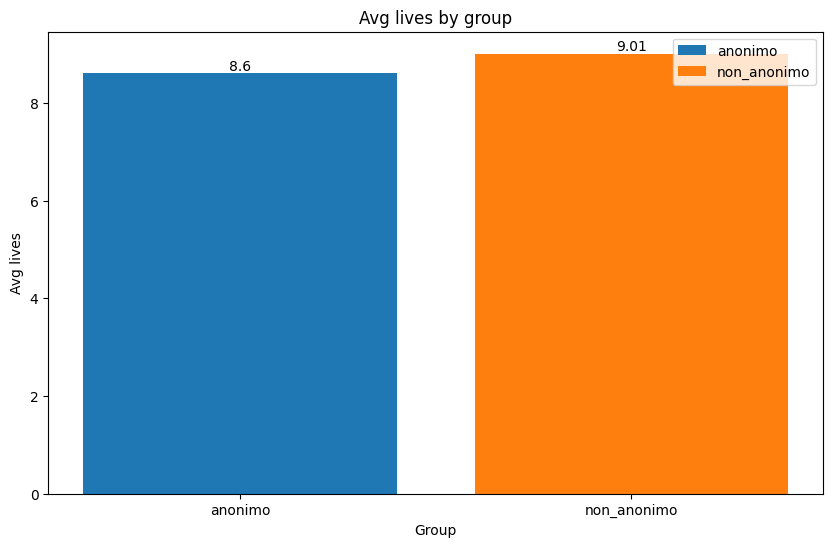

In [33]:



donation_amounts = []
devices = []

for participant_data in data:
    donation_amounts.append(participant_data['donation1']['lives'])
    devices.append(participant_data['pre']['experiment_group'])

df_plot = pd.DataFrame({                      'donation_amount': donation_amounts,
                       'device': devices})

grouped_data = df_plot.groupby(['device'])['donation_amount'].mean().reset_index()

plt.figure(figsize=(10, 6))

for device in grouped_data['device'].unique():
    device_data = grouped_data[grouped_data['device'] == device]
    plt.bar(device_data['device'], device_data['donation_amount'], label=device)


for i, v in enumerate(grouped_data['donation_amount']):
    plt.text(i, v, str(round(v, 2)), ha='center', va='bottom')

plt.xlabel('Group')
plt.ylabel('Avg lives')
plt.title('Avg lives by group')
plt.legend()
plt.show()

### NO (Referral Bar Chart)

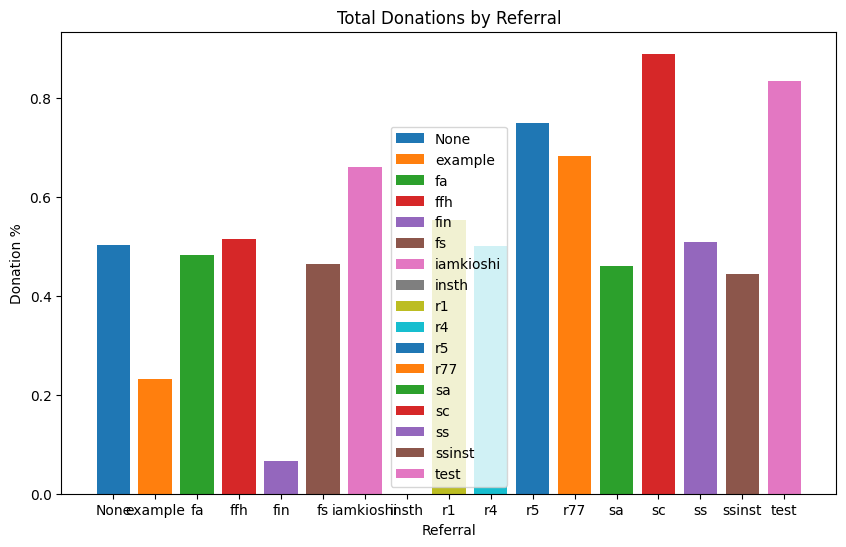

In [34]:


import matplotlib.pyplot as plt


donation_amounts = []
devices = []

for participant_data in data:
    donation_amounts.append(participant_data['donation1']['amount'] / participant_data['donation1']['lives'])
    devices.append(participant_data['pre']['refer'] if 'refer' in participant_data['pre'] else 'None')

import pandas as pd
df_plot = pd.DataFrame({                      'donation_amount': donation_amounts,
                       'device': devices})

grouped_data = df_plot.groupby(['device'])['donation_amount'].mean().reset_index()

plt.figure(figsize=(10, 6))

for device in grouped_data['device'].unique():
    device_data = grouped_data[grouped_data['device'] == device]
    plt.bar(device_data['device'], device_data['donation_amount'], label=device)

plt.xlabel('Referral')
plt.ylabel('Donation %')
plt.title('Total Donations by Referral')
plt.legend()
plt.show()

### NO ( 2nd Match score by group bar chart, not adj per anon 0 donatio)

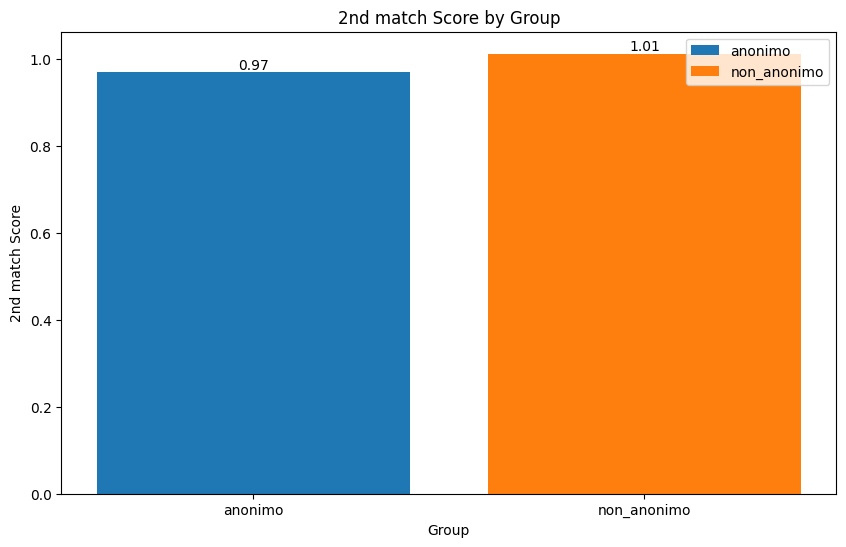

In [35]:

import matplotlib.pyplot as plt


donation_amounts = []
devices = []

for participant_data in data:
    donation_amounts.append(((participant_data['totalScore'] if 'totalScore' in participant_data else 0) - 500 * participant_data['donation1']['lives']) / (500* participant_data['donation1']['lives']))
    devices.append(participant_data['pre']['experiment_group'])

import pandas as pd
df_plot = pd.DataFrame({                      'donation_amount': donation_amounts,
                       'device': devices})

grouped_data = df_plot.groupby(['device'])['donation_amount'].mean().reset_index()

plt.figure(figsize=(10, 6))

for device in grouped_data['device'].unique():
    device_data = grouped_data[grouped_data['device'] == device]
    plt.bar(device_data['device'], device_data['donation_amount'], label=device)

plt.xlabel('Group')
plt.ylabel('2nd match Score')
plt.title('2nd match Score by Group')

for i, v in enumerate(grouped_data['donation_amount']):
    plt.text(i, v, str(round(v, 2)), ha='center', va='bottom')
plt.legend()
plt.show()

### NO Evaluation by group bar chart

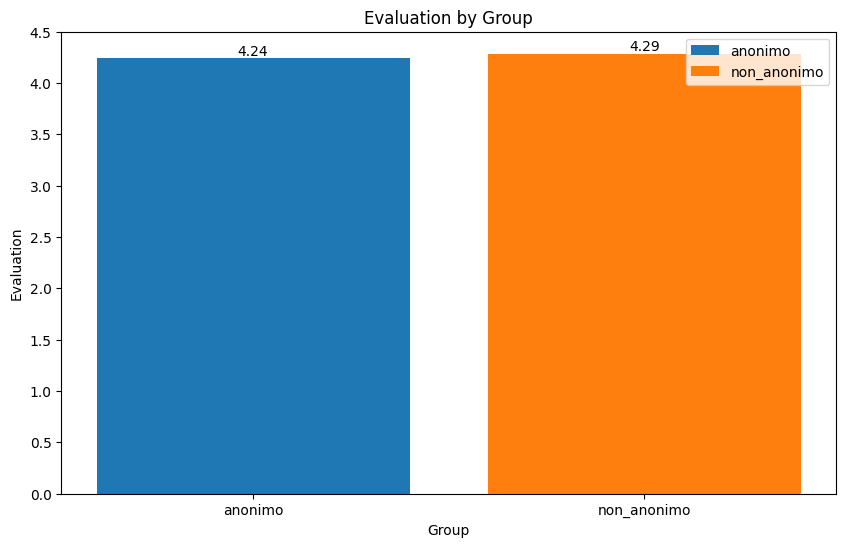

In [36]:

import matplotlib.pyplot as plt


donation_amounts = []
devices = []

for participant_data in data:
    donation_amounts.append(((participant_data['post']['overall_evaluation'] if 'overall_evaluation' in participant_data['post'] else 0)))
    devices.append(participant_data['pre']['experiment_group'])

import pandas as pd
df_plot = pd.DataFrame({                      'donation_amount': donation_amounts,
                       'device': devices})

grouped_data = df_plot.groupby(['device'])['donation_amount'].mean().reset_index()

plt.figure(figsize=(10, 6))

for device in grouped_data['device'].unique():
    device_data = grouped_data[grouped_data['device'] == device]
    plt.bar(device_data['device'], device_data['donation_amount'], label=device)

plt.xlabel('Group')
plt.ylabel('Evaluation')
plt.title('Evaluation by Group')

for i, v in enumerate(grouped_data['donation_amount']):
    plt.text(i, v, str(round(v, 2)), ha='center', va='bottom')
plt.legend()
plt.show()

### NO Education donation scatter + boxplot

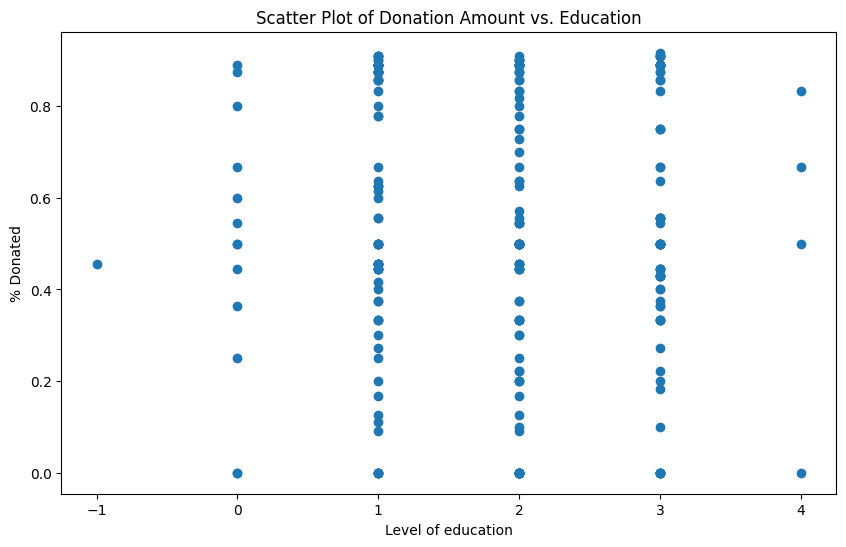

In [37]:

donation_amounts = []
donation_gen = []
experiment_groups = []

for participant_data in data:
    donation_amounts.append(participant_data['donation1']['amount'] / participant_data['donation1']['lives'])
    donation_gen.append(participant_data['pre']['education'] if 'education' in participant_data['pre'] else 'None')


d = {'doctorate': 4, 'None': -1, 'high_school': 1, 'master': 3, 'bachelor': 2, 'no_degree': 0}
donation_gen = [d[x] for x in donation_gen]

plt.figure(figsize=(10, 6))
plt.scatter(donation_gen, donation_amounts)
plt.xlabel('Level of education')
plt.ylabel('% Donated')
plt.title('Scatter Plot of Donation Amount vs. Education')
plt.show()

In [38]:
exit()

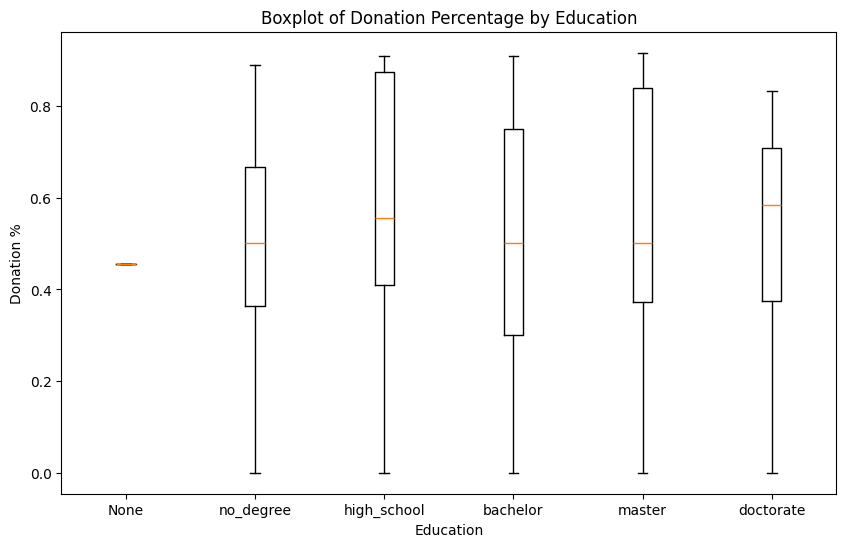

In [39]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for edu in d.keys():
    plt.boxplot([donation_amounts[i] for i in range(len(donation_amounts)) if donation_gen[i] == d[edu]], positions=[d[edu]], labels=[edu])

plt.xlabel('Education')
plt.ylabel('Donation %')
plt.title('Boxplot of Donation Percentage by Education')
plt.show()

### NO Employment status donation boxplot

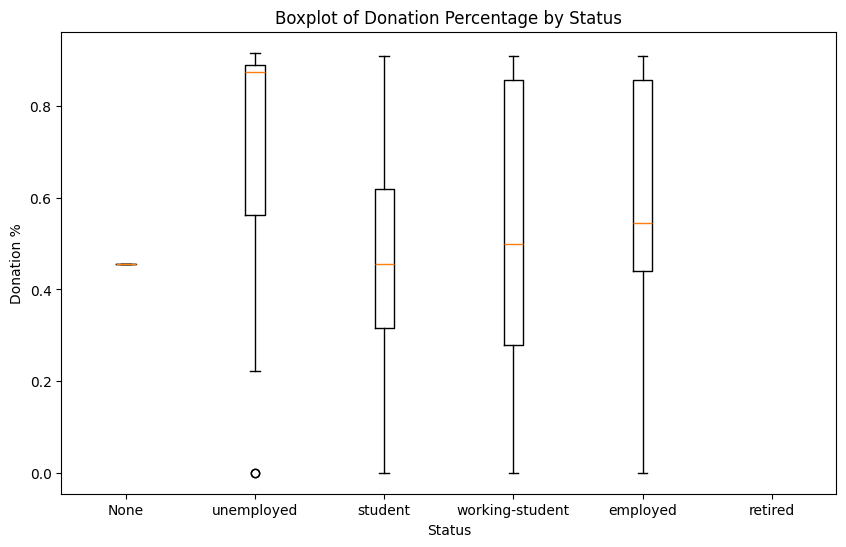

In [40]:

donation_amounts = []
donation_gen = []
experiment_groups = []

for participant_data in data:
    donation_amounts.append(participant_data['donation1']['amount'] / participant_data['donation1']['lives'])
    donation_gen.append(participant_data['pre']['employment_status'] if 'employment_status' in participant_data['pre'] else 'None')



d = {'retired': 4, 'None': -1, 'student': 1, 'employed': 3, 'working-student': 2, 'unemployed': 0}
donation_gen = [d[x] for x in donation_gen]

plt.figure(figsize=(10, 6))
for edu in d.keys():
    plt.boxplot([donation_amounts[i] for i in range(len(donation_amounts)) if donation_gen[i] == d[edu]], positions=[d[edu]], labels=[edu])

plt.xlabel('Status')
plt.ylabel('Donation %')
plt.title('Boxplot of Donation Percentage by Status')
plt.show()

### NO Income level donation boxplot (partial data)

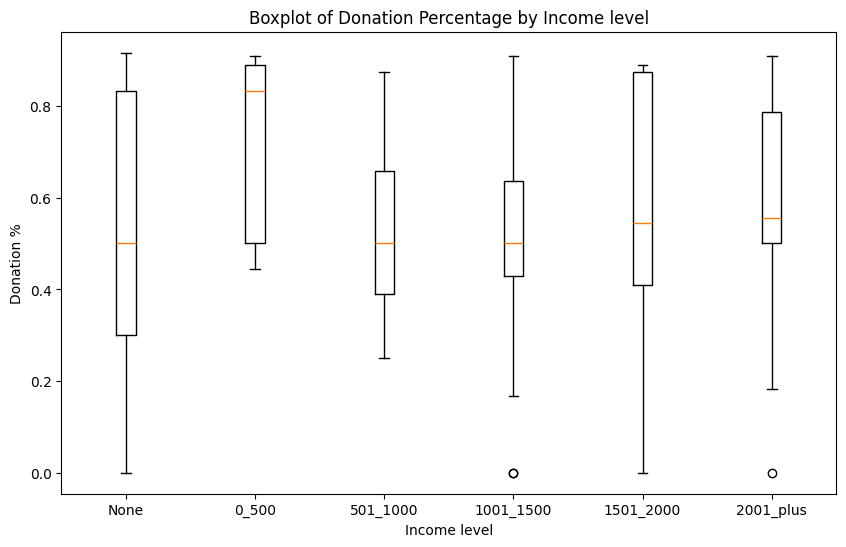

In [41]:

donation_amounts = []
donation_gen = []
experiment_groups = []

for participant_data in data:
    donation_amounts.append(participant_data['donation1']['amount'] / participant_data['donation1']['lives'])
    donation_gen.append(participant_data['pre']['income'] if 'income' in participant_data['pre'] else 'None')


d = {'2001_plus': 4, 'None': -1, '1501_2000': 3, '1001_1500': 2, '501_1000': 1, '0_500': 0}
donation_gen = [d[x] for x in donation_gen]

plt.figure(figsize=(10, 6))
for edu in d.keys():
    plt.boxplot([donation_amounts[i] for i in range(len(donation_amounts)) if donation_gen[i] == d[edu]], positions=[d[edu]], labels=[edu])

plt.xlabel('Income level')
plt.ylabel('Donation %')
plt.title('Boxplot of Donation Percentage by Income level')
plt.show()

### NO Gender Donation Boxplot

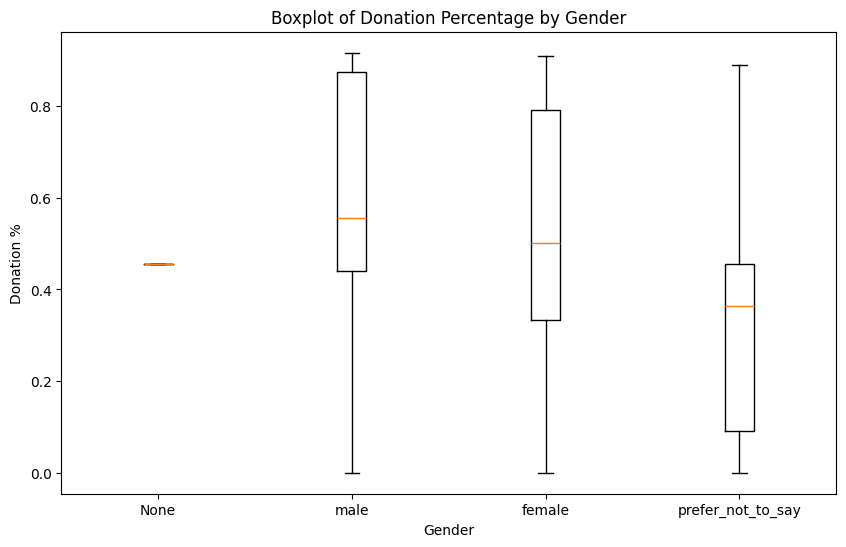

In [42]:

donation_amounts = []
donation_gen = []
experiment_groups = []

for participant_data in data:
    donation_amounts.append(participant_data['donation1']['amount'] / participant_data['donation1']['lives'])
    donation_gen.append(participant_data['pre']['gender'] if 'gender' in participant_data['pre'] else 'None')


d = {'male': 0, 'female': 1, 'prefer_not_to_say': 2, 'None': -1}
donation_gen = [d[x] for x in donation_gen]

plt.figure(figsize=(10, 6))
for edu in d.keys():
    plt.boxplot([donation_amounts[i] for i in range(len(donation_amounts)) if donation_gen[i] == d[edu]], positions=[d[edu]], labels=[edu])

plt.xlabel('Gender')
plt.ylabel('Donation %')
plt.title('Boxplot of Donation Percentage by Gender')
plt.show()

###NO Age group Donation Boxplot

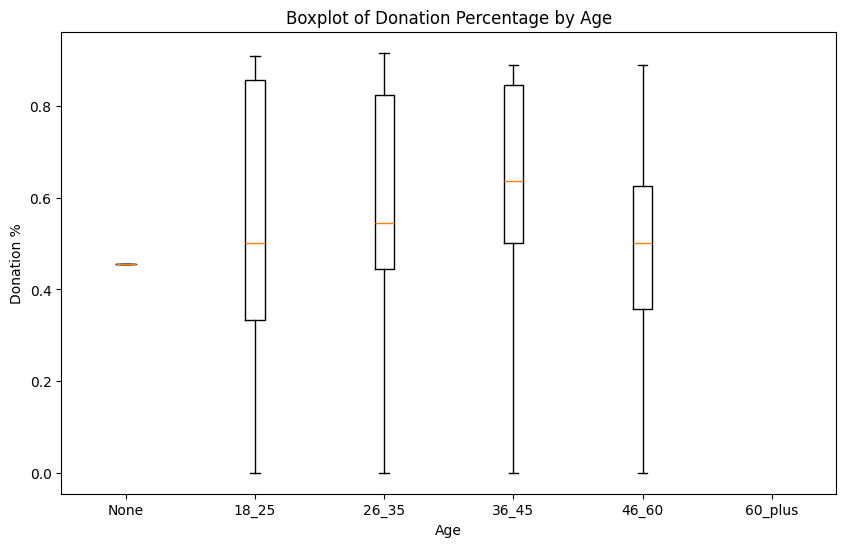

In [43]:

donation_amounts = []
donation_gen = []
experiment_groups = []

for participant_data in data:
    donation_amounts.append(participant_data['donation1']['amount'] / participant_data['donation1']['lives'])
    donation_gen.append(participant_data['pre']['age_group'] if 'age_group' in participant_data['pre'] else 'None')


d = {"18_25": 0, "26_35": 1, "36_45": 2, "46_60": 3,"60_plus": 4, "None": -1 }
donation_gen = [d[x] for x in donation_gen]

plt.figure(figsize=(10, 6))
for edu in d.keys():
    plt.boxplot([donation_amounts[i] for i in range(len(donation_amounts)) if donation_gen[i] == d[edu]], positions=[d[edu]], labels=[edu])

plt.xlabel('Age')
plt.ylabel('Donation %')
plt.title('Boxplot of Donation Percentage by Age')
plt.show()

### Boxplot of Donation Percentage by Overall evaluation

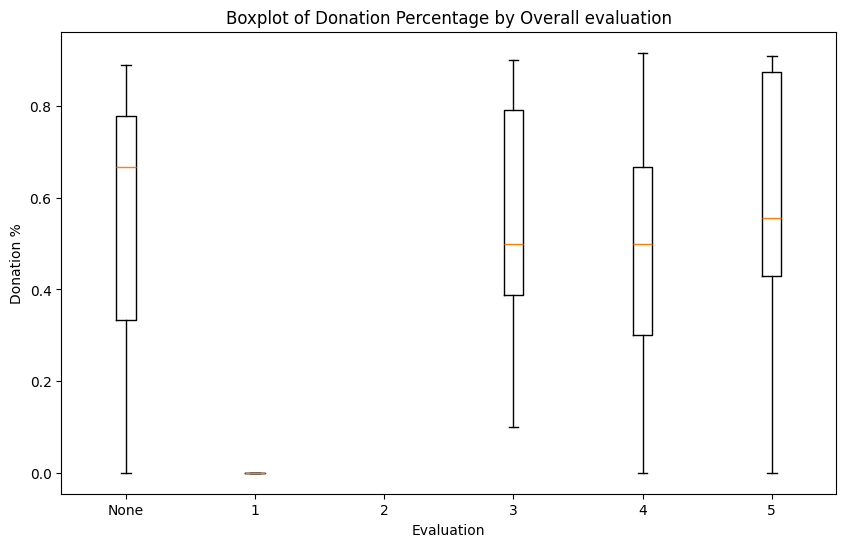

In [44]:

donation_amounts = []
donation_gen = []
experiment_groups = []

for participant_data in data:
    donation_amounts.append(participant_data['donation1']['amount'] / participant_data['donation1']['lives'])
    donation_gen.append(participant_data['post']['overall_evaluation'] if 'overall_evaluation' in participant_data['post'] else 'None')


d = {"1": 0, "2": 1, "3": 2, "4": 3,"5": 4, "None": -1 }
donation_gen = [d[str(x)] for x in donation_gen]

plt.figure(figsize=(10, 6))
for edu in d.keys():
    plt.boxplot([donation_amounts[i] for i in range(len(donation_amounts)) if donation_gen[i] == d[edu]], positions=[d[edu]], labels=[edu])

plt.xlabel('Evaluation')
plt.ylabel('Donation %')
plt.title('Boxplot of Donation Percentage by Overall evaluation')
plt.show()

In [35]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

all_data = []
for participant_data in data:
    try:
        donation_amount = participant_data['donation1']['amount'] / participant_data['donation1']['lives']
        age_group = participant_data['pre']['age_group']
        employment_status = participant_data['pre']['employment_status']
        education = participant_data['pre']['education']
        gender = participant_data['pre']['gender']
        experiment_group = participant_data['pre']['experiment_group']
        country = participant_data['pre']['country']
        generous = participant_data['pre']['personal_info']['generous']
        competitive = participant_data['pre']['personal_info']['competitive']
        all_data.append([donation_amount, age_group, employment_status, education, gender, experiment_group, generous, competitive])
    except KeyError:
        continue

df = pd.DataFrame(all_data, columns=['donation_amount', 'age_group', 'employment_status', 'education', 'gender', 'experiment_group', 'generous', 'competitive'])

df = pd.get_dummies(df, columns=['age_group', 'employment_status', 'education', 'gender', 'experiment_group'], drop_first=True)
# df.head()

In [36]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols, glm
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.diagnostic import linear_reset
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.metrics import accuracy_score


# Rename columns to match the R code variables
df.rename(columns={
    'donation_amount': 'LivDon',
    'age_group_26_35': 'age_26_35',
    'age_group_36_45': 'age_36_45',
    'age_group_46_60': 'age_46_60',
    'employment_status_student': 'empl_student',
    'employment_status_unemployed': 'empl_unemployed',
    'employment_status_working-student': 'empl_working_student',
    'education_doctorate': 'educ_doctorate',
    'education_high_school': 'educ_high_school',
    'education_master': 'educ_master',
    'education_no_degree': 'educ_no_degree',
    'gender_male': 'male',
    'generous': 'generous',
    'competitive': 'competitive',
    'gender_prefer_not_to_say': 'gender_pnts',
    'experiment_group_non_anonimo': 'NonAnon'
}, inplace=True)



# OLS

In [37]:


formula1 = "LivDon ~ age_26_35 + age_36_45 + age_46_60 + empl_student + empl_unemployed + empl_working_student + educ_doctorate + educ_high_school + educ_master + educ_no_degree + male + gender_pnts + NonAnon + generous + competitive"
model1 = ols(formula=formula1, data=df).fit()
print(model1.summary())




# Joint significance test using likelihood ratio
joint_test_vars = [
    "age_26_35", "age_36_45", "age_46_60",
    "empl_student", "empl_unemployed", "empl_working_student",
    "educ_doctorate", "educ_high_school", "educ_master", "educ_no_degree"
]
joint_test_formula = "LivDon ~ " + " + ".join(joint_test_vars)
restricted_model = ols(formula=joint_test_formula, data=df).fit()
lr_stat = 2 * (model1.llf - restricted_model.llf)
df_diff = model1.df_model - restricted_model.df_model
from scipy.stats import chi2

print()

p_value = chi2.sf(lr_stat, df_diff)
print(f"Likelihood Ratio Test p-value: {p_value}")


reset_test_result = linear_reset(model1, power=2)
print()

print(f"RESET test result: {reset_test_result}")
if reset_test_result.pvalue < 0.05:
    print("The OLS model may have specification issues.")
else:
    print("The OLS model is likely well-specified.")


from statsmodels.stats.diagnostic import het_breuschpagan

bp_test = het_breuschpagan(model1.resid, model1.model.exog)
print()
print(f"Breusch-Pagan Test p-value: {bp_test[1]}")
if bp_test[1] < 0.05:
    print("Evidence of heteroskedasticity in OLS model.")
else:
    print("No evidence of heteroskedasticity.")




from statsmodels.stats.diagnostic import het_white

white_test = het_white(model1.resid, model1.model.exog)
print()

print(f"White Test p-value: {white_test[1]}")
if white_test[1] < 0.05:
    print("Evidence of heteroskedasticity (White Test).")
else:
    print("No evidence of heteroskedasticity.")


ols_robust = model1.get_robustcov_results(cov_type='HC1')
print(ols_robust.summary())



                            OLS Regression Results                            
Dep. Variable:                 LivDon   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     3.144
Date:                Fri, 17 Jan 2025   Prob (F-statistic):           0.000105
Time:                        13:47:11   Log-Likelihood:                -19.693
No. Observations:                 249   AIC:                             71.39
Df Residuals:                     233   BIC:                             127.7
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [38]:

# OLS Regression simplified
formula1 = "LivDon ~ empl_student + empl_unemployed + empl_working_student + male + gender_pnts + NonAnon"
model1 = ols(formula=formula1, data=df).fit()
print(model1.summary())



joint_test_vars = [
     "NonAnon",
]
joint_test_formula = "LivDon ~ " + " + ".join(joint_test_vars)
print(joint_test_formula)
restricted_model = ols(formula=joint_test_formula, data=df).fit()
lr_stat = 2 * (model1.llf - restricted_model.llf)
df_diff = model1.df_model - restricted_model.df_model
from scipy.stats import chi2

print()

p_value = chi2.sf(lr_stat, df_diff)
print(f"Likelihood Ratio Test p-value: {p_value}")


# RESET Test
reset_test_result = linear_reset(model1, power=2)
print()

print(f"RESET test result: {reset_test_result}")
if reset_test_result.pvalue < 0.05:
    print("The OLS model may have specification issues.")
else:
    print("The OLS model is likely well-specified.")


from statsmodels.stats.diagnostic import het_breuschpagan

bp_test = het_breuschpagan(model1.resid, model1.model.exog)
print()
print(f"Breusch-Pagan Test p-value: {bp_test[1]}")
if bp_test[1] < 0.05:
    print("Evidence of heteroskedasticity in OLS model.")
else:
    print("No evidence of heteroskedasticity.")




from statsmodels.stats.diagnostic import het_white

white_test = het_white(model1.resid, model1.model.exog)
print()

print(f"White Test p-value: {white_test[1]}")
if white_test[1] < 0.05:
    print("Evidence of heteroskedasticity (White Test).")
else:
    print("No evidence of heteroskedasticity.")


ols_robust = model1.get_robustcov_results(cov_type='HC1')
print(ols_robust.summary())



                            OLS Regression Results                            
Dep. Variable:                 LivDon   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     6.331
Date:                Fri, 17 Jan 2025   Prob (F-statistic):           3.34e-06
Time:                        13:47:17   Log-Likelihood:                -24.490
No. Observations:                 249   AIC:                             62.98
Df Residuals:                     242   BIC:                             87.60
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

# Linear Prob

In [39]:


# Linear Probability Model
df['donor'] = (df['LivDon'] > 0).astype(int)
formula2 = "donor ~  empl_student + empl_unemployed + empl_working_student + educ_doctorate + educ_high_school + educ_master + educ_no_degree + male + gender_pnts + NonAnon"
model2 = glm(formula=formula2, data=df, family=sm.families.Binomial()).fit()
print(model2.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:                  donor   No. Observations:                  249
Model:                            GLM   Df Residuals:                      238
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -71.790
Date:                Fri, 17 Jan 2025   Deviance:                       143.58
Time:                        13:47:24   Pearson chi2:                     308.
No. Iterations:                     6   Pseudo R-squ. (CS):            0.08857
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

# Probit

In [40]:
# Probit Model
model3 = glm(formula=formula2, data=df, family=sm.families.Binomial(link=sm.families.links.probit())).fit()
print(model3.summary())

pseudo_r2 = 1 - (model3.llf / model3.llnull)
print(f"Pseudo R^2: {pseudo_r2:.4f}")
if pseudo_r2 > 0.2:
    print("Good fit for the Probit model.")
else:
    print("Probit model fit could be improved.")

# Accuracy of Probit Model
predicted_probit = (model3.fittedvalues > 0.5).astype(int)
accuracy = accuracy_score(df['donor'], predicted_probit)
print(f"Accuracy of Probit model: {accuracy}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  donor   No. Observations:                  249
Model:                            GLM   Df Residuals:                      238
Model Family:                Binomial   Df Model:                           10
Link Function:                 probit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -72.171
Date:                Fri, 17 Jan 2025   Deviance:                       144.34
Time:                        13:47:28   Pearson chi2:                     306.
No. Iterations:                     8   Pseudo R-squ. (CS):            0.08578
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The probit link alias is deprecated. Use Probit instead. The probit link alias will be removed after the 0.15.0 release.
  warnings.warn(


# Groups randomized assumption test

In [41]:
from scipy.stats import ttest_ind, chi2_contingency
import pandas as pd

baseline = df[df['NonAnon'] == 0]
treatment = df[df['NonAnon'] == 1]

results = []

for column in df.columns:
    if column == 'NonAnon':
        continue

    if df[column].dtype == 'float64' or df[column].dtype == 'int64':
        t_stat, p_val = ttest_ind(baseline[column], treatment[column], nan_policy='omit')
        results.append({
            'Variable': column,
            'Test': 'T-Test',
            'Statistic': t_stat,
            'P-Value': p_val
        })
    elif df[column].dtype == 'object' or df[column].nunique() <= 10:
        contingency_table = pd.crosstab(df[column], df['NonAnon'])
        chi2, p_val, dof, _ = chi2_contingency(contingency_table)
        results.append({
            'Variable': column,
            'Test': 'Chi-Square',
            'Statistic': chi2,
            'P-Value': p_val
        })

results_df = pd.DataFrame(results)
print(results_df)



                Variable        Test  Statistic   P-Value
0                 LivDon      T-Test  -4.116750  0.000052
1               generous      T-Test   1.584029  0.114467
2            competitive      T-Test   0.719629  0.472434
3              age_26_35  Chi-Square   0.364554  0.545988
4              age_36_45  Chi-Square   0.432597  0.510718
5              age_46_60  Chi-Square   0.000000  1.000000
6           empl_student  Chi-Square   0.867618  0.351616
7        empl_unemployed  Chi-Square   0.234830  0.627966
8   empl_working_student  Chi-Square   0.425733  0.514090
9         educ_doctorate  Chi-Square   0.230215  0.631364
10      educ_high_school  Chi-Square   0.022939  0.879615
11           educ_master  Chi-Square   0.000000  1.000000
12        educ_no_degree  Chi-Square   0.000000  1.000000
13                  male  Chi-Square   0.003197  0.954910
14           gender_pnts  Chi-Square   0.377535  0.538926
15                 donor      T-Test  -3.894456  0.000127
